In [1]:
import numpyro
numpyro.set_host_device_count(8)

import numpy as np

from jax import numpy as jnp
from jax import random
from tqdm import trange
from numpyro import plate, sample, factor
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS, init_to_median
from corner import corner

import matplotlib.pyplot as plt
import scienceplots

from scipy.stats import norm

SPEED_OF_LIGHT = 299_792.458

Mock with 100 points created.


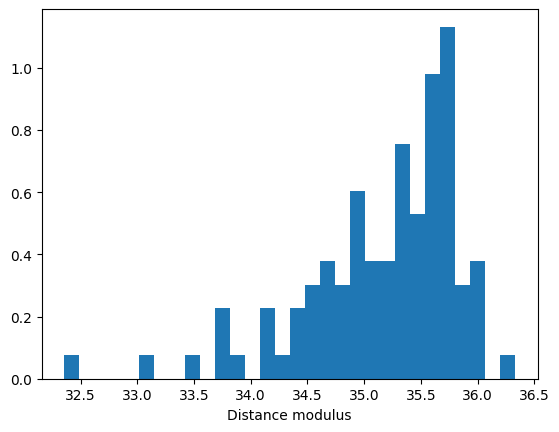

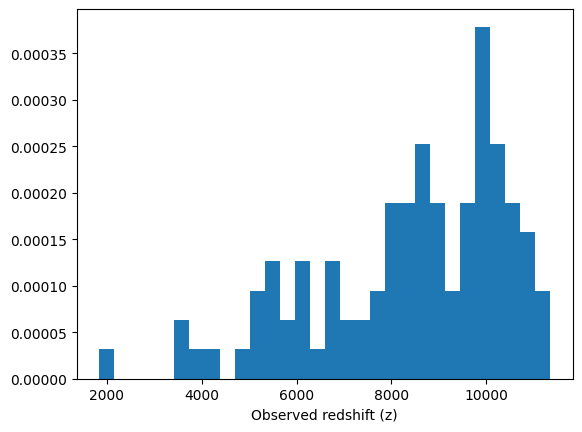

In [2]:
def r2cz(r, H0):
    return r * H0

def r2mu(r):
    return 5 * jnp.log10(r) + 25


def make_mock(Rmax, H0, sigma_v, e_mu, npoints, seed=42, ):
    gen = np.random.default_rng(seed)

    r_true = Rmax * gen.uniform(0, 1, npoints)**(1/3)

    mu = gen.normal(r2mu(r_true), e_mu, )
    cz = gen.normal(r2cz(r_true, H0=H0), sigma_v, )

    return mu, cz


mock_kwargs = dict(Rmax=150, H0=75, sigma_v=300, e_mu=0.2)

mu, cz = make_mock(**mock_kwargs, npoints=100)

print(f"Mock with {mu.size} points created.")

plt.figure()
plt.hist(mu, bins=30, density=True, )
plt.xlabel("Distance modulus")
plt.show()

plt.figure()
plt.hist(cz, bins=30, density=True, )
plt.xlabel("Observed redshift (z)")
plt.show()


In [3]:
def model(mu, cz, e_mu, Rmax, sigma_v, k):
    H0 = sample("H0", Uniform(0.1, 200))

    with plate("points", len(mu)):
        r = sample("r_true", Uniform(0, Rmax))
        factor("lp_prior", k * jnp.log(r))

        sample("r_obs", Normal(r2mu(r), e_mu), obs=mu)
        sample("cz_obs", Normal(r2cz(r, H0=H0), sigma_v), obs=cz)

In [12]:
def run_inferences(k):
    num_warmup = 250
    num_samples = 1000
    num_chains = 8
    nrepeat = 10000
    progress_bar = nrepeat == 1

    npoints = 1000

    biases_H0 = []
    dH0 = []
    dlogH0 = []

    for i in trange(nrepeat, desc="Running MCMC", disable=progress_bar):
        mu, cz = make_mock(**mock_kwargs, npoints=npoints, seed=42 + i)

        if k == "frequentist":
            m = cz > 0
            logH0 = jnp.log10(cz[m]) - 0.2 * mu[m] + 5
            samples ={
                "logH0": logH0,
                "H0": 10**(logH0)
                }
        else:
            kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
            mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples,
                        num_chains=num_chains, progress_bar=progress_bar)
            mcmc.run(
                random.PRNGKey(i),
                mu=jnp.asarray(mu),
                cz=jnp.asarray(cz),
                e_mu=mock_kwargs["e_mu"],
                Rmax=mock_kwargs["Rmax"],
                sigma_v=mock_kwargs["sigma_v"],
                k=k,
            )
            samples = mcmc.get_samples()
            if progress_bar:
                mcmc.print_summary()

        # Compute the bias for this run
        biases_H0.append((np.mean(samples["H0"], axis=0) - mock_kwargs["H0"]) / np.std(samples["H0"], axis=0))
        dH0.append(np.mean(samples["H0"] - mock_kwargs["H0"]))
        dlogH0.append(np.mean(samples["logH0"] - np.log10(mock_kwargs["H0"])))

    biases_H0 = np.asarray(biases_H0)
    dH0 = np.asanyarray(dH0)
    dlogH0 = np.asanyarray(dlogH0)

    return samples, biases_H0, dH0, dlogH0, 


In [13]:
# __, biases_vol = run_inferences(k=2)
# __, biases_flatdistmod = run_inferences(k=-1)


__, biases_freq, dH0_freq, dlogH0_freq = run_inferences(k="frequentist")

Running MCMC: 100%|██████████| 10000/10000 [00:03<00:00, 3206.19it/s]


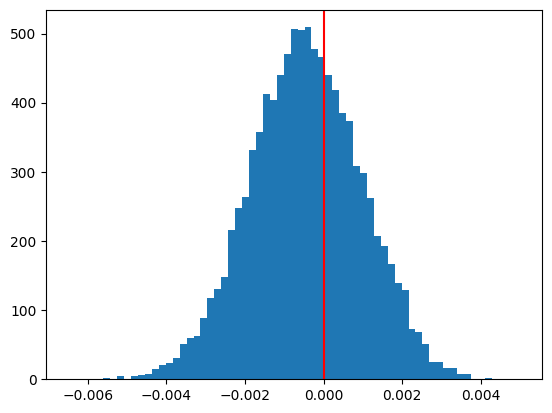

In [14]:
plt.figure()
plt.hist(dlogH0_freq, bins="auto")

plt.axvline(0, c="red")

plt.show()